In [13]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

In [14]:
model_path = os.path.expanduser("~/Desktop/Repositories/monodepth2/models")

## Setting up network and loading weights

In [15]:
model_name = "weights_5"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join(model_path, model_name, "encoder.pth")
depth_decoder_path = os.path.join(model_path, model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and perform inference

In [16]:
def plot_example(i, image_path, f):

    if i >= 5:
        i += 5

    input_image = pil.open(image_path).convert('RGB')
    original_width, original_height = input_image.size

    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

    with torch.no_grad():
        features = encoder(input_image_pytorch)
        outputs = depth_decoder(features)

    disp = outputs[("disp", 0)]

    disp_resized = torch.nn.functional.interpolate(disp,
        (original_height, original_width), mode="bilinear", align_corners=False)

    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    title = image_path.split('/')[-1]

    # plt.figure(f)
    ax = f.add_subplot(4, 5, i+1)
    # ax.subplot(4, 5, i+1)
    ax.imshow(input_image)
    ax.set_title(title, fontsize=22)
    ax.axis('off')

    # plt.subplot(4, 5, i+6)
    ax = f.add_subplot(4, 5, i+1+5)
    ax.imshow(disp_resized_np, cmap='magma', vmax=vmax)
    ax.set_title(title + "Disparity prediction", fontsize=22)
    ax.axis('off');

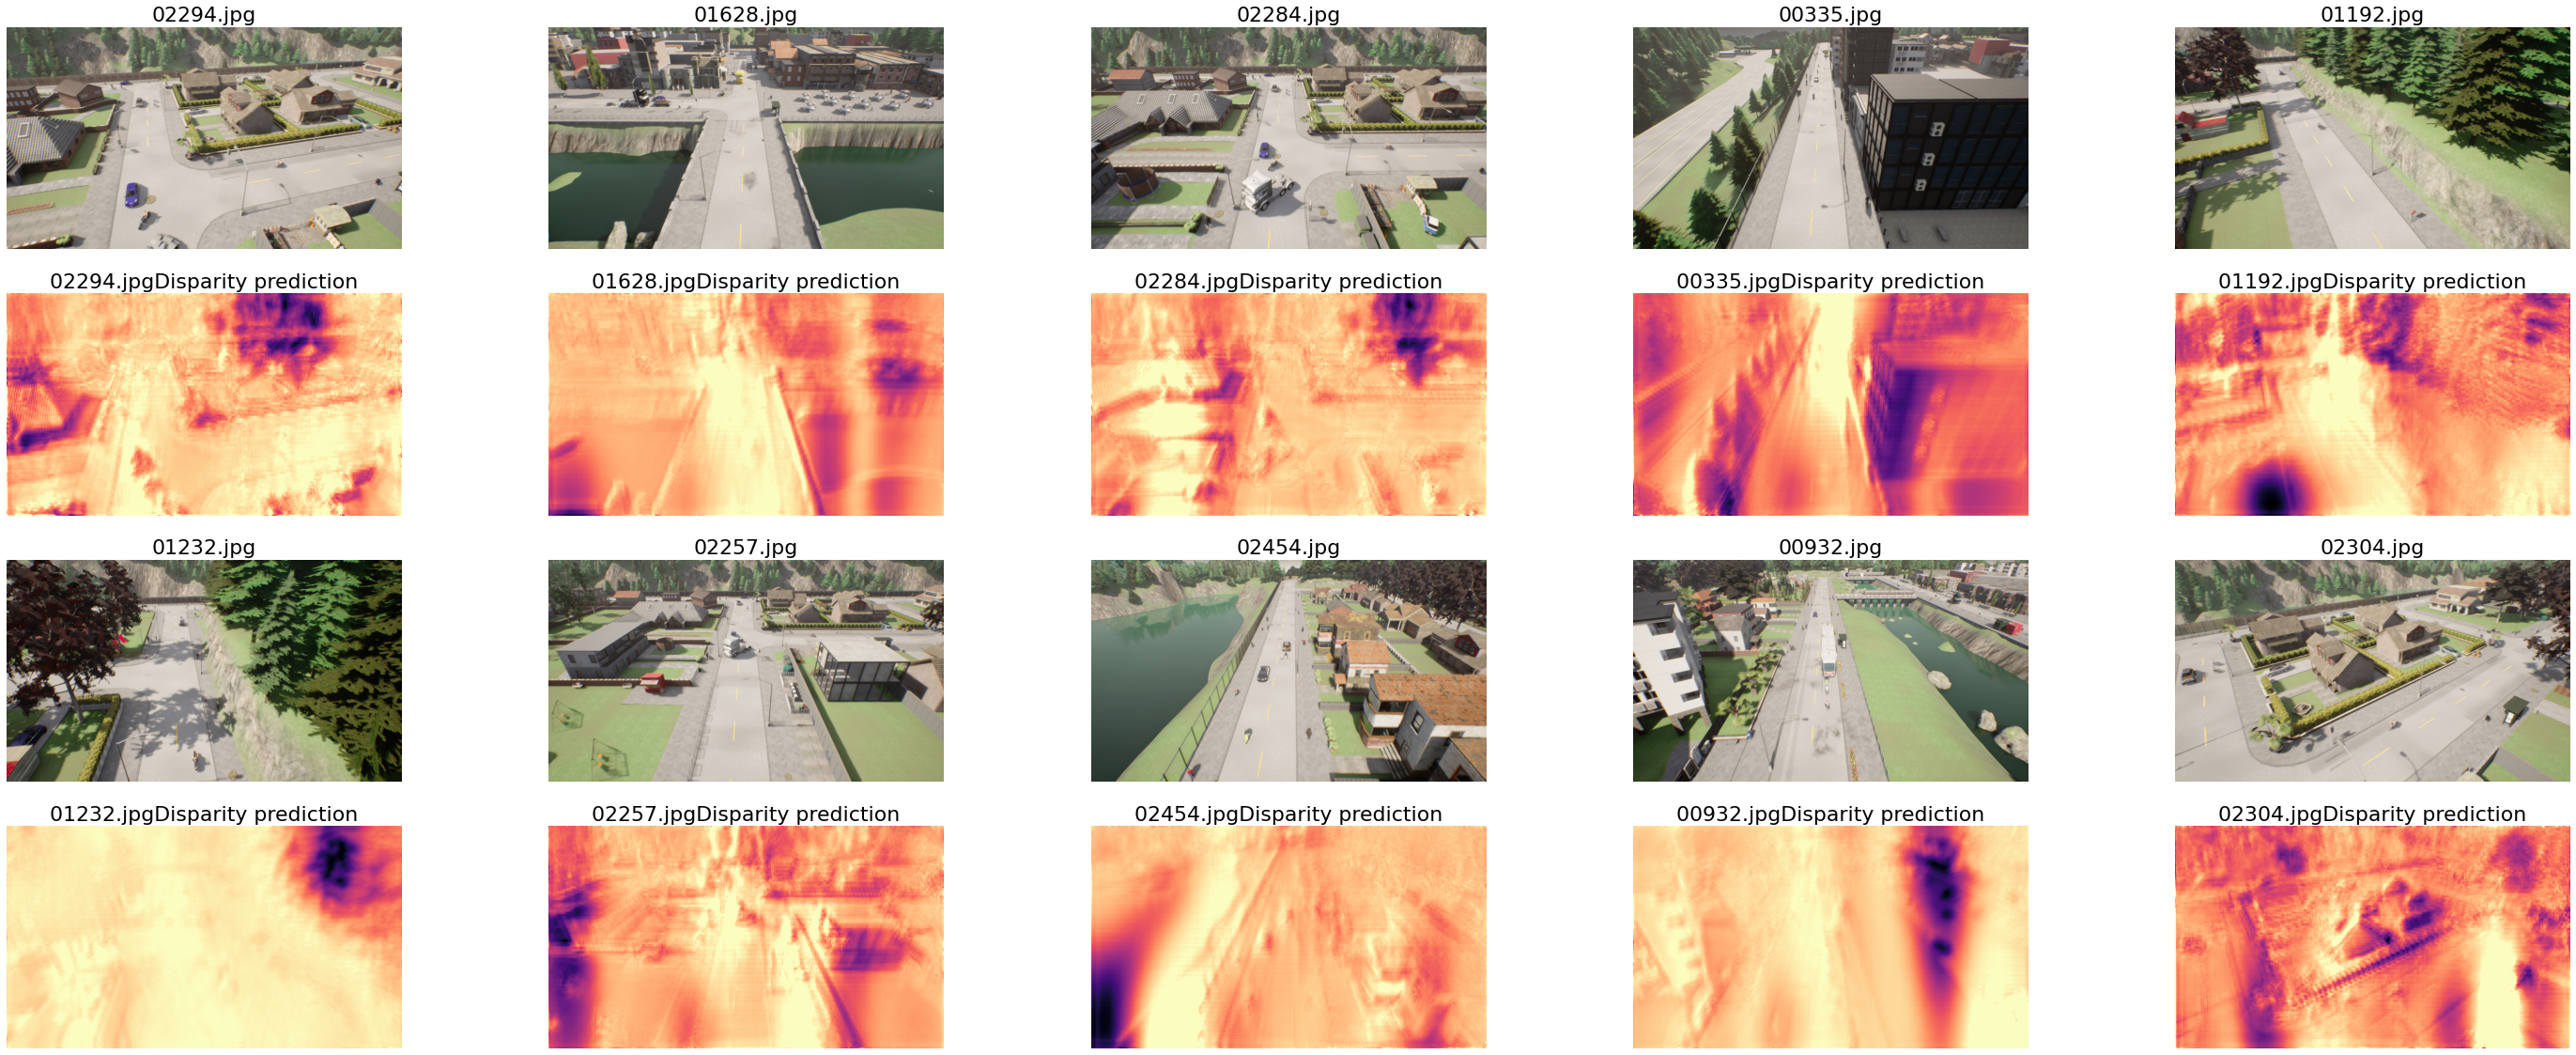

In [17]:
import  random

f = plt.figure(figsize=(50, 20))
data_path = os.path.expanduser("~/Desktop/Repositories/monodepth2/data/Town01_Opt_120_color/Town01_Opt_120/ClearNoon/height20m/rgb/")
for i in range(10):
    n = random.randint(0, 3000)
    example = os.path.join(data_path, f"{n:05d}.jpg")
    plot_example(i, example,f)